In [ ]:
!pip install d2l

## import modul

In [ ]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

generate some data

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## initializing model parameter 

In [ ]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1, )))
    return [w, b]

In [ ]:
# defining L2 norm penalty

def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

In [ ]:
# defining the training loop

def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            d2l.sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(w).numpy())

L2 norm of w: 20.536253


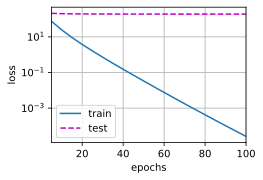

In [ ]:
# training without regularization

train(lambd=0)

L2 norm of w: 0.55901545


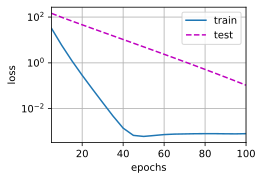

In [ ]:
# train with weight decay

train(lambd=3)

## concise implementation

In [ ]:
def train_concise(wd):
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(wd)))
    net.build(input_shape=(1, num_inputs))
    w, b = net.trainable_variables
    loss = tf.keras.losses.MeanSquaredError()
    num_epochs, lr = 100, 0.003
    trainer = tf.keras.optimizers.SGD(learning_rate=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # `tf.keras` requires retrieving and adding the losses from
                # layers manually for custom training loop.
                l = loss(net(X), y) + net.losses
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(net.get_weights()[0]).numpy())

L2 norm of w: 1.3741269


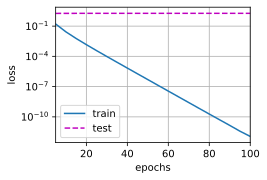

In [ ]:
train_concise(0)

L2 norm of w: 0.04100442


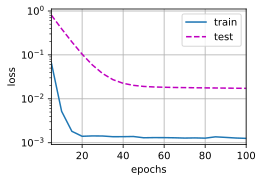

In [ ]:
train_concise(3)